In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [ ]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [ ]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [ ]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [ ]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [ ]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1> BiLSTM1 - CNN1 </h1>

In [ ]:
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAvgPool1D
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 256)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 126, 64)           49216     
                                                                 
 dropout_7 (Dropout)         (None, 126, 64)           0         
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 64)               

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 24s 102ms/step - loss: 1.0282 - accuracy: 0.5768 - val_loss: 0.5773 - val_accuracy: 0.7842
Epoch 2/10
58/58 [==============================] - 2s 35ms/step - loss: 0.4361 - accuracy: 0.8356 - val_loss: 0.3036 - val_accuracy: 0.8889
Epoch 3/10
58/58 [==============================] - 2s 30ms/step - loss: 0.2549 - accuracy: 0.9026 - val_loss: 0.2133 - val_accuracy: 0.9152
Epoch 4/10
58/58 [==============================] - 2s 31ms/step - loss: 0.1891 - accuracy: 0.9271 - val_loss: 0.1521 - val_accuracy: 0.9343
Epoch 5/10
58/58 [==============================] - 2s 28ms/step - loss: 0.1446 - accuracy: 0.9415 - val_loss: 0.1320 - val_accuracy: 0.9461
Epoch 6/10
58/58 [==============================] - 2s 27ms/step - loss: 0.1358 - accuracy: 0.9441 - val_loss: 0.1213 - val_accuracy: 0.9420
Epoch 7/10
58/58 [==============================] - 2s 39ms/step - loss: 0.1257 - accuracy: 0.9494 - val_loss: 0.1155 - val_accuracy: 0.9488
Epoch 8/10


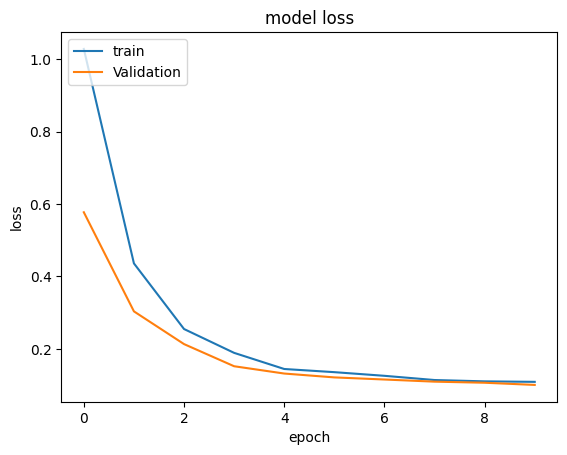

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

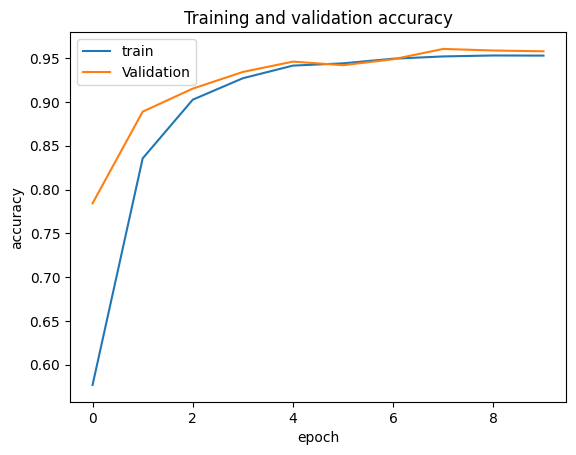

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 10ms/step
[[458   3  31   0   4   0]
 [  0 440  31   0   0   0]
 [  0   0 420   0   0   0]
 [  0  20   0 368  98   5]
 [  3   3   0  52 474   0]
 [  0  27   0   0   0 510]]
0.9060061079063454
0.9054504422137494
              precision    recall  f1-score   support

           0       0.99      0.92      0.96       496
           1       0.89      0.93      0.91       471
           2       0.87      1.00      0.93       420
           3       0.88      0.75      0.81       491
           4       0.82      0.89      0.86       532
           5       0.99      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

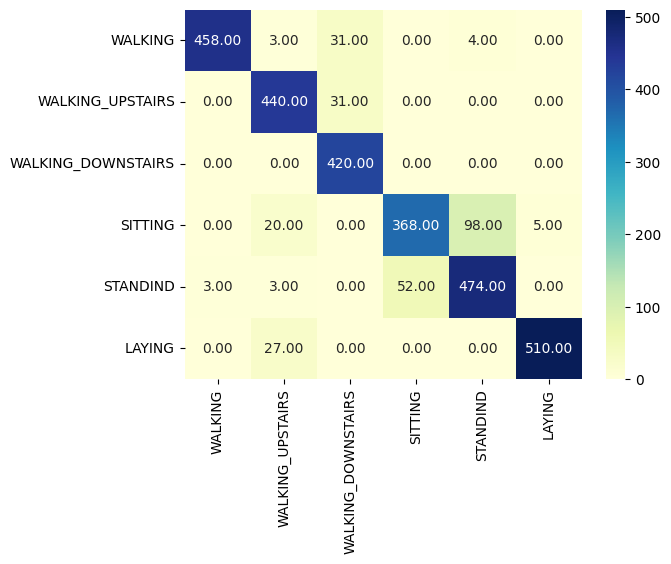

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> CNN1 - BiLSTM1 </h1>

In [ ]:
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAvgPool1D
model = Sequential()

model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.5))

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 126, 64)           1792      
                                                                 
 dropout_9 (Dropout)         (None, 126, 64)           0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 256)               197632    
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 12s 62ms/step - loss: 0.9102 - accuracy: 0.5998 - val_loss: 0.5730 - val_accuracy: 0.7203
Epoch 2/10
58/58 [==============================] - 2s 26ms/step - loss: 0.5266 - accuracy: 0.7756 - val_loss: 0.4031 - val_accuracy: 0.8332
Epoch 3/10
58/58 [==============================] - 1s 26ms/step - loss: 0.4897 - accuracy: 0.8062 - val_loss: 0.4795 - val_accuracy: 0.8055
Epoch 4/10
58/58 [==============================] - 2s 28ms/step - loss: 0.3864 - accuracy: 0.8523 - val_loss: 0.3035 - val_accuracy: 0.8908
Epoch 5/10
58/58 [==============================] - 2s 41ms/step - loss: 0.2511 - accuracy: 0.9106 - val_loss: 0.2445 - val_accuracy: 0.9116
Epoch 6/10
58/58 [==============================] - 2s 29ms/step - loss: 0.2367 - accuracy: 0.9139 - val_loss: 0.2371 - val_accuracy: 0.9053
Epoch 7/10
58/58 [==============================] - 1s 20ms/step - loss: 0.2853 - accuracy: 0.9119 - val_loss: 0.4218 - val_accuracy: 0.8291
Epoch 8/10
5

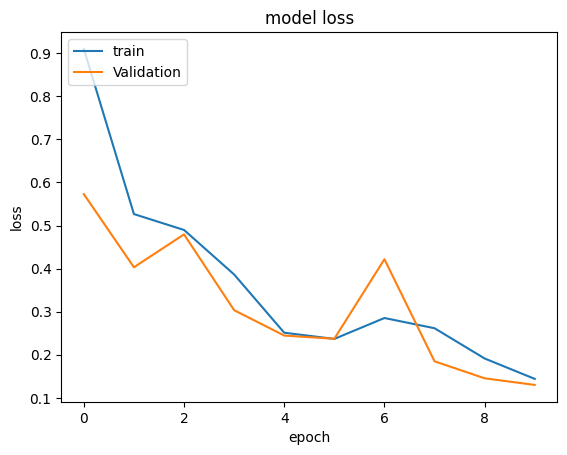

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

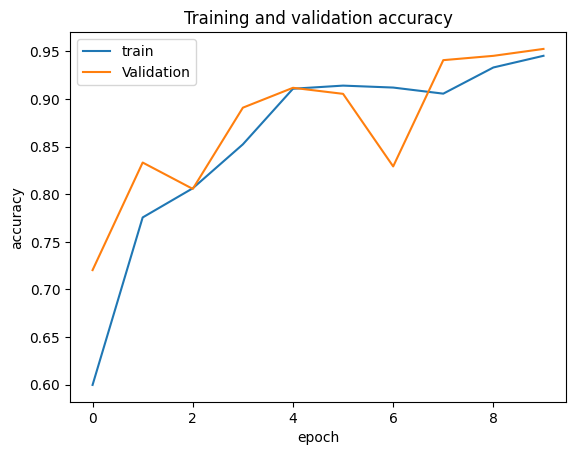

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 6ms/step
[[451   9  36   0   0   0]
 [ 10 427  34   0   0   0]
 [ 14   6 400   0   0   0]
 [  0  24   0 392  75   0]
 [  3   4   0 100 425   0]
 [  0  27   0   0   0 510]]
0.8839497794367153
0.8840601159391005
              precision    recall  f1-score   support

           0       0.94      0.91      0.93       496
           1       0.86      0.91      0.88       471
           2       0.85      0.95      0.90       420
           3       0.80      0.80      0.80       491
           4       0.85      0.80      0.82       532
           5       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.88      0.89      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

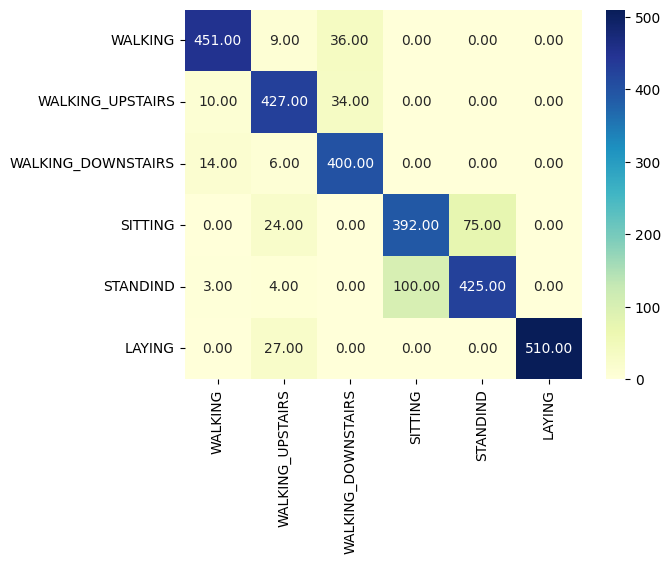

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - CNN1 </h1>

In [ ]:
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAvgPool1D
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 128, 256)          394240    
 onal)                                                           
                                                                 
 dropout_12 (Dropout)        (None, 128, 256)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 126, 64)           49216     
                                                                 
 dropout_13 (Dropout)        (None, 126, 64)          

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 19s 118ms/step - loss: 0.9769 - accuracy: 0.5862 - val_loss: 0.6154 - val_accuracy: 0.7511
Epoch 2/10
58/58 [==============================] - 3s 55ms/step - loss: 0.4372 - accuracy: 0.8388 - val_loss: 0.3136 - val_accuracy: 0.8835
Epoch 3/10
58/58 [==============================] - 3s 57ms/step - loss: 0.2696 - accuracy: 0.8976 - val_loss: 0.1962 - val_accuracy: 0.9284
Epoch 4/10
58/58 [==============================] - 3s 52ms/step - loss: 0.1761 - accuracy: 0.9310 - val_loss: 0.1649 - val_accuracy: 0.9343
Epoch 5/10
58/58 [==============================] - 3s 52ms/step - loss: 0.1382 - accuracy: 0.9444 - val_loss: 0.1305 - val_accuracy: 0.9411
Epoch 6/10
58/58 [==============================] - 3s 51ms/step - loss: 0.1299 - accuracy: 0.9484 - val_loss: 0.1210 - val_accuracy: 0.9501
Epoch 7/10
58/58 [==============================] - 3s 51ms/step - loss: 0.1157 - accuracy: 0.9501 - val_loss: 0.1107 - val_accuracy: 0.9565
Epoch 8/10


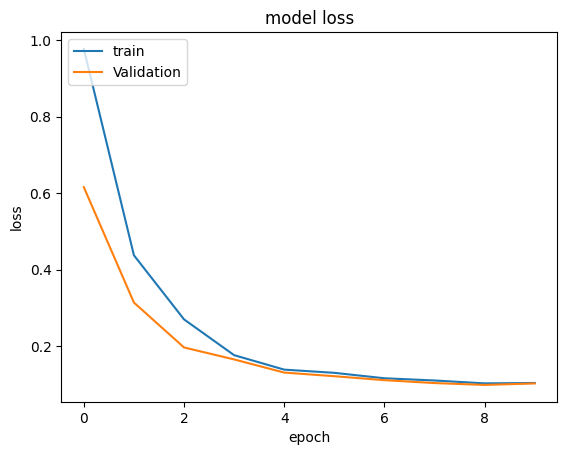

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

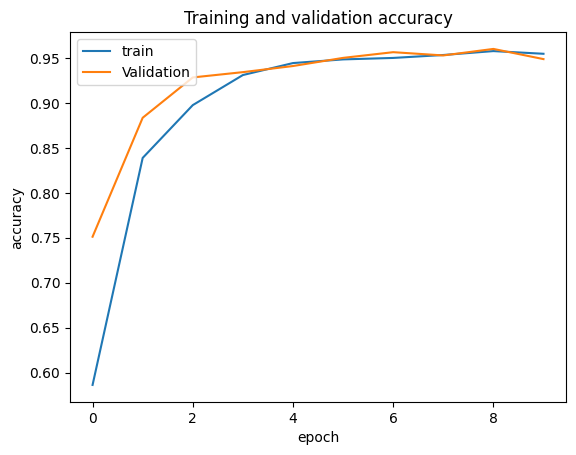

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 12ms/step
[[424  39  29   0   4   0]
 [  8 424  38   0   1   0]
 [  2   3 415   0   0   0]
 [  0  20   0 373  92   6]
 [  0   0   0  49 483   0]
 [  0   2   0   0   0 535]]
0.9005768578215134
0.8997558234668123
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       496
           1       0.87      0.90      0.88       471
           2       0.86      0.99      0.92       420
           3       0.88      0.76      0.82       491
           4       0.83      0.91      0.87       532
           5       0.99      1.00      0.99       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

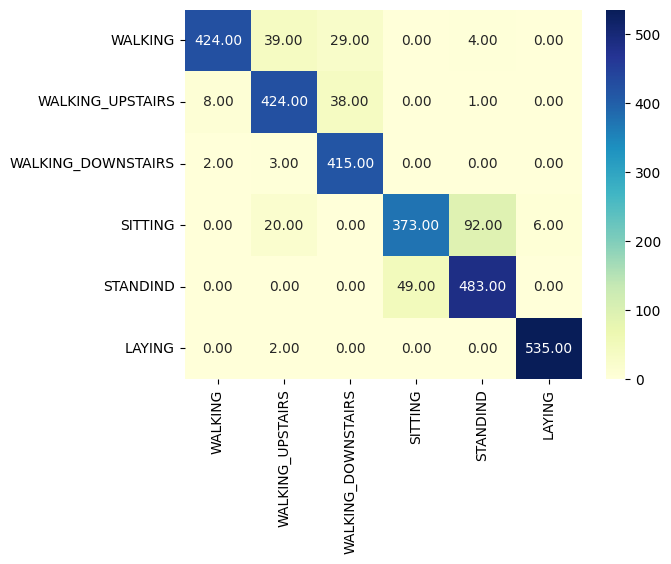

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM1 - CNN2 </h1>

In [ ]:
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAvgPool1D
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_14 (Dropout)        (None, 128, 256)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 126, 64)           49216     
                                                                 
 dropout_15 (Dropout)        (None, 126, 64)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 124, 64)           12352     
                                                                 
 dropout_16 (Dropout)        (None, 124, 64)           0         
                                                      

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 11s 55ms/step - loss: 1.1162 - accuracy: 0.5184 - val_loss: 0.6808 - val_accuracy: 0.7058
Epoch 2/10
58/58 [==============================] - 2s 30ms/step - loss: 0.5460 - accuracy: 0.7837 - val_loss: 0.5015 - val_accuracy: 0.8300
Epoch 3/10
58/58 [==============================] - 2s 37ms/step - loss: 0.3550 - accuracy: 0.8720 - val_loss: 0.3005 - val_accuracy: 0.8835
Epoch 4/10
58/58 [==============================] - 2s 35ms/step - loss: 0.2151 - accuracy: 0.9174 - val_loss: 0.1738 - val_accuracy: 0.9302
Epoch 5/10
58/58 [==============================] - 2s 29ms/step - loss: 0.1484 - accuracy: 0.9389 - val_loss: 0.1416 - val_accuracy: 0.9470
Epoch 6/10
58/58 [==============================] - 2s 31ms/step - loss: 0.1278 - accuracy: 0.9460 - val_loss: 0.1194 - val_accuracy: 0.9470
Epoch 7/10
58/58 [==============================] - 2s 32ms/step - loss: 0.1156 - accuracy: 0.9502 - val_loss: 0.1305 - val_accuracy: 0.9365
Epoch 8/10
5

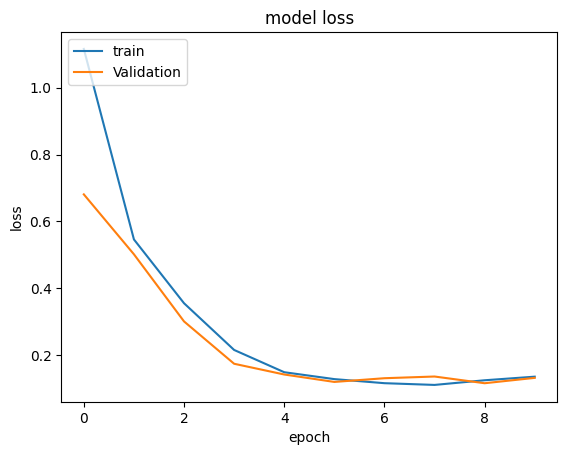

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

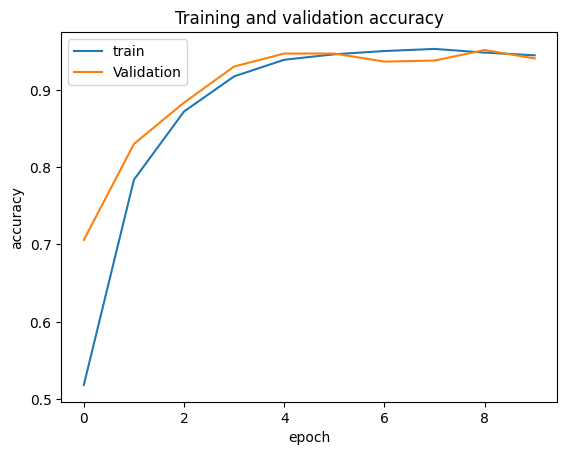

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 2s 8ms/step
[[458  16  22   0   0   0]
 [  4 445  22   0   0   0]
 [  2   4 414   0   0   0]
 [  0  21   0 306 164   0]
 [  5   0   0  27 500   0]
 [  0  27   0   0   0 510]]
0.8934509670851714
0.8909213719532567
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.87      0.94      0.90       471
           2       0.90      0.99      0.94       420
           3       0.92      0.62      0.74       491
           4       0.75      0.94      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.90      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

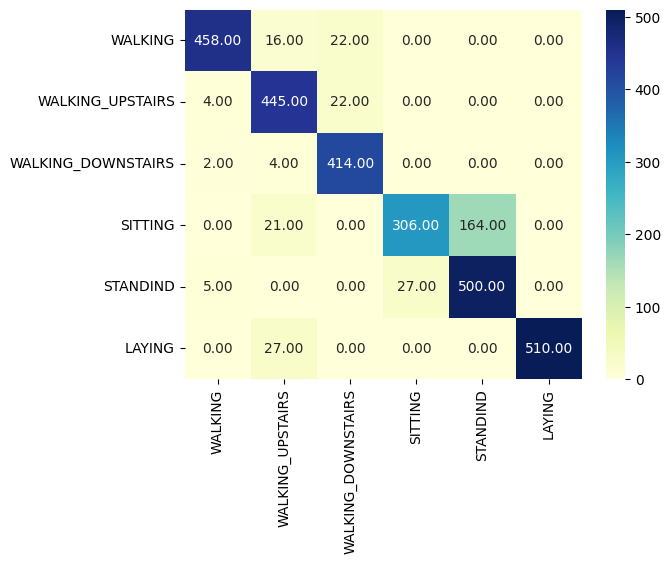

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1> BiLSTM2 - CNN2 </h1>

In [ ]:
from tensorflow.keras.layers import LSTM, Conv1D, GlobalAvgPool1D
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, return_sequences = True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling1D())
model.add(Flatten())

model.add(Dense(units = 64, activation='relu'))
# Softmax layer
model.add(Dense(n_outputs, activation = 'softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, n_timesteps,n_features))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirecti  (None, 128, 256)          141312    
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 128, 256)          0         
                                                                 
 bidirectional_10 (Bidirect  (None, 128, 256)          394240    
 ional)                                                          
                                                                 
 dropout_18 (Dropout)        (None, 128, 256)          0         
                                                                 
 conv1d_9 (Conv1D)           (None, 126, 64)           49216     
                                                                 
 dropout_19 (Dropout)        (None, 126, 64)          

In [ ]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 22s 92ms/step - loss: 1.0689 - accuracy: 0.5424 - val_loss: 0.7832 - val_accuracy: 0.6405
Epoch 2/10
58/58 [==============================] - 3s 49ms/step - loss: 0.5684 - accuracy: 0.7650 - val_loss: 0.3360 - val_accuracy: 0.8767
Epoch 3/10
58/58 [==============================] - 3s 50ms/step - loss: 0.2541 - accuracy: 0.9017 - val_loss: 0.2161 - val_accuracy: 0.9234
Epoch 4/10
58/58 [==============================] - 3s 51ms/step - loss: 0.1645 - accuracy: 0.9348 - val_loss: 0.1556 - val_accuracy: 0.9306
Epoch 5/10
58/58 [==============================] - 3s 50ms/step - loss: 0.1329 - accuracy: 0.9440 - val_loss: 0.1157 - val_accuracy: 0.9533
Epoch 6/10
58/58 [==============================] - 3s 51ms/step - loss: 0.1180 - accuracy: 0.9490 - val_loss: 0.1247 - val_accuracy: 0.9447
Epoch 7/10
58/58 [==============================] - 3s 51ms/step - loss: 0.1245 - accuracy: 0.9452 - val_loss: 0.1040 - val_accuracy: 0.9538
Epoch 8/10
5

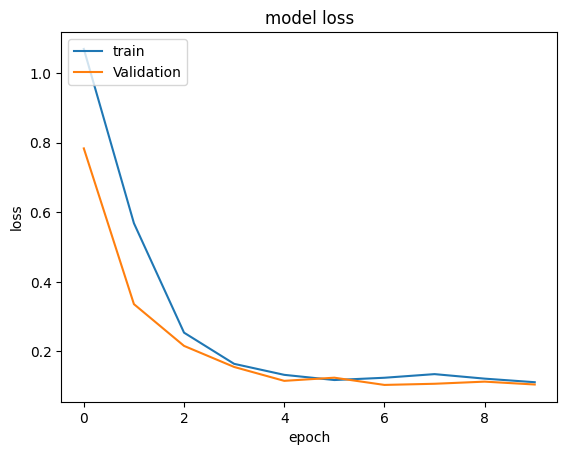

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

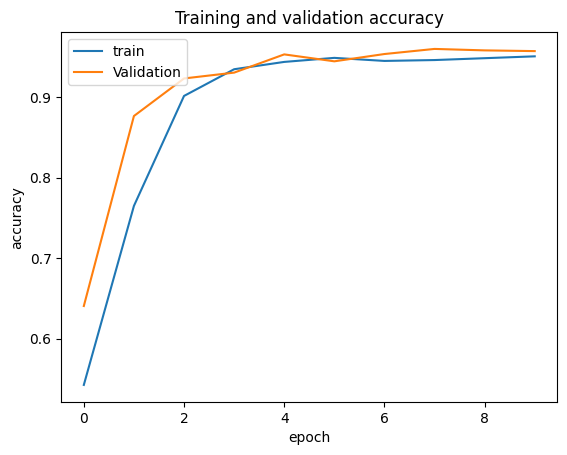

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 3s 10ms/step
[[458  13  25   0   0   0]
 [  6 447  18   0   0   0]
 [  1   1 418   0   0   0]
 [  0   1   2 380  85  23]
 [  3   0   0  98 431   0]
 [  0   0   0   0   0 537]]
0.9063454360366474
0.9055576857118515
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       496
           1       0.97      0.95      0.96       471
           2       0.90      1.00      0.95       420
           3       0.79      0.77      0.78       491
           4       0.84      0.81      0.82       532
           5       0.96      1.00      0.98       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg       0.91      0.91      0.91      2947



<Axes: >

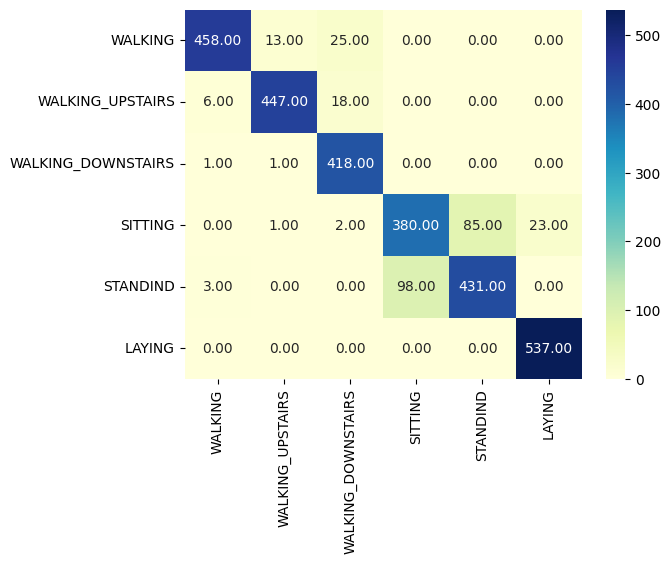

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')